In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [49]:
df = pd.read_csv("final_dataset_hinglish.csv")

In [50]:
df.head()

,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [51]:
df['label'].unique()

array([-1,  0])

Dataframe manipulation

In [52]:
def perform_data_manipulation():
    df = pd.read_csv("final_dataset_hinglish.csv")
    
    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index, "label"] = 1
    return df

In [53]:
df = perform_data_manipulation()

In [54]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [55]:
df['label'].unique()

array([1, 0])

In [56]:
df.shape[0]

67855

Classification using Pie Chart

In [57]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.tight_layout()
    
    plt.show()

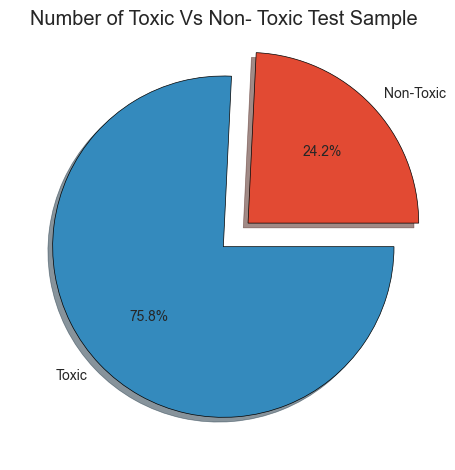

In [58]:
performdatadistribution(df)

In [59]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [60]:
df.head(1)

,headline,label
0,cock suck before you piss around on my work,1


In [61]:
# Define the remove_pattern function
def remove_pattern(input_txt, pattern):
    import re
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# Modify datasetCleaning function
def datasetCleaning(df):
    combined_df = pd.concat([df, df], ignore_index=True)

    # Ensure 'headline' column contains strings and handle missing values
    combined_df['headline'] = combined_df['headline'].astype(str).fillna('')

    # Remove @ user using vectorized operation
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")

    # Remove extra letters (non-alphabetic characters)
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)

    # Remove short words (less than 3 characters)
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

    return combined_df, df

<>:17: SyntaxWarning: invalid escape sequence '\w'
<>:17: SyntaxWarning: invalid escape sequence '\w'
C:\Users\yasin\AppData\Local\Temp\ipykernel_40000\4170477131.py:17: SyntaxWarning: invalid escape sequence '\w'
  combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")


In [62]:
combined_df, df =datasetCleaning(df)

In [63]:
combined_df.head()

,headline,label,tidy_tweet
0,cock suck before you piss around on my work,1,cock suck before you piss around work
1,you are gay or antisemmitian archangel white ...,1,you are gay antisemmitian archangel white tige...
2,fuck your filthy mother in the ass dry,1,fuck your filthy mother the ass dry
3,get fuck ed up get fuck ed up got a drink t...,1,get fuck get fuck got drink that you cant put ...
4,stupid peace of shit stop deleting my stuff ...,1,stupid peace shit stop deleting stuff ass hole...


Dataset Splitting

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [66]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 135710
Number of rows in the train dataset: 108568
Number of rows in the test dataset: 27142


c:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['kill', 'ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [67]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [68]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result
        

In [69]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 2.287304162979126 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 3.292527437210083 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.01624274253845215 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 27.776559114456177 sec
Training Time : AdaBoostClassifier


c:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoostClassifier finished in 9.418136835098267 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 307.23749923706055 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.14510846138000488 sec


In [70]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [71]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,27.776559,0.175579,0.933940,0.976798,0.956431,0.984601,0.955897,0.990188,0.956966,0.979076
1,BaggingClassifier,307.237499,1.751271,0.932761,0.974587,0.955763,0.983273,0.952876,0.980639,0.958668,0.985921
2,LinearSVC,2.287304,0.000000,0.911097,0.952666,0.941705,0.968911,0.935760,0.964262,0.947727,0.973605
3,LogisticRegression,3.292527,0.015722,0.889175,0.921303,0.928822,0.949285,0.904632,0.927431,0.954340,0.972195
4,MultinomialNB,0.016243,0.009399,0.857564,0.879873,0.913006,0.925938,0.849717,0.868741,0.986482,0.991198
5,SGDClassifier,0.145108,0.000000,0.857122,0.869667,0.911602,0.919135,0.858013,0.867197,0.972332,0.977690
6,AdaBoostClassifier,9.418137,1.578025,0.813536,0.816272,0.887556,0.889124,0.817133,0.819010,0.971262,0.972365


In [72]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.016243,0.000000,0.813536,0.816272,0.887556,0.889124,0.817133,0.819010,0.947727,0.972195
max,307.237499,1.751271,0.933940,0.976798,0.956431,0.984601,0.955897,0.990188,0.986482,0.991198


Summary IN Graph

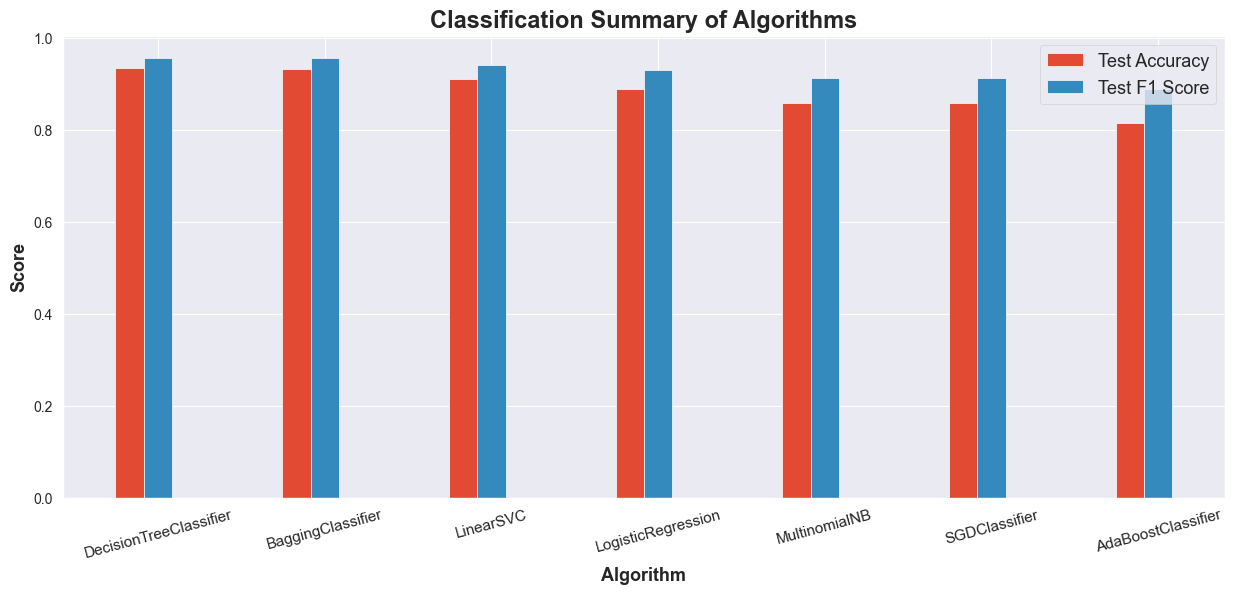

In [73]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

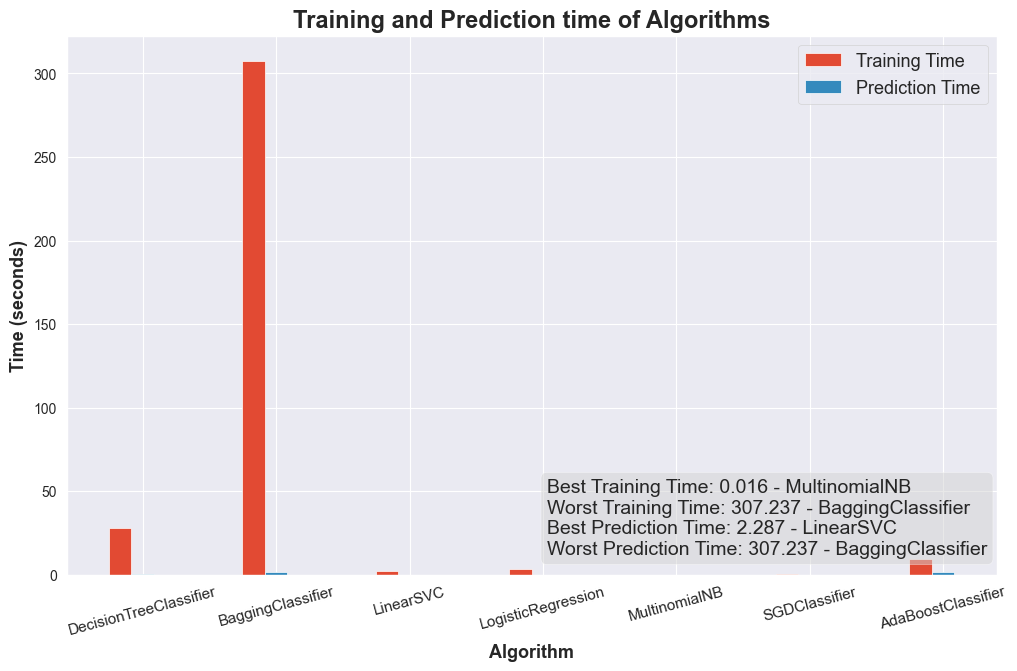

In [74]:

best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [75]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [76]:
data = ["Hello"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[0]
non-bulling


c:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['kill', 'ninad'] not in stop_words.
  warnings.warn(


Fine Tuining

In [77]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [78]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9121288040674969
F1 Score :  0.9423035053342043
Precision :  0.9376083188908145
Recall:  0.9470459518599562


In [79]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))